In [85]:
import os
from PIL import Image
import cv2
import pandas as pd
import numpy as np
import fitz

def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)
    
    

data_path = "../data/2023_04_희태_POC데이터/수학"

naver_ocr_json =  os.path.join(data_path,"naver_ocr")
if not os.path.isdir(naver_ocr_json):
    os.makedirs(naver_ocr_json)

sample_image_dir_path = os.path.join(data_path,"sampling")
json_file_dir_path = os.path.join(data_path,"json")





In [86]:

## 이미지 -> 네이버 OCR 인식 함수
import json
import requests
import uuid
import time

def send_naver_ocr(path):
    api_url = "https://gsayd3fesc.apigw.ntruss.com/custom/v1/16872/475a5777d1cd1c2351b160840bcc6824d24e5e6e20d9cdb7dbcb7e87421eed01/general"
    secret_key = "dE5FQndOZkVSZkRUQmVSaEpvSXZjdkJvV29XRXdTdUg="
    files = [('file', open(path,'rb'))]

    request_json = {'images': [{'format': 'png',
                                    'name': 'demo'
                                }],
                        'requestId': str(uuid.uuid4()),
                        'version': 'V2',
                        'timestamp': int(round(time.time() * 1000))
                    }
    
    payload = {'message': json.dumps(request_json).encode('UTF-8')}
    
    headers = {
    'X-OCR-SECRET': secret_key,
    }
    
    response = requests.request("POST", api_url, headers=headers, data=payload, files=files)
    result = response.json()

    return result


In [87]:
from tqdm import tqdm

## 샘플링된 이미지 naver OCR로 보내고 인식결과 json으로 저장
img_file = sorted([file for file in os.listdir(sample_image_dir_path) if file.endswith('png')])

for image_file_name in tqdm(img_file):
    image_full_path = os.path.join(sample_image_dir_path,image_file_name)
    naver_ocr_json_file_path = os.path.join(naver_ocr_json,image_file_name)
    
    # 네이버 OCR 결과파일이 없다면 send_naver_ocr 함수로 보내고 결과파일 json으로 저장 
    if not os.path.exists(naver_ocr_json_file_path[:-4]+'.json'):
        result_json = send_naver_ocr(image_full_path)
        with open(naver_ocr_json_file_path[:-4]+'.json', 'w') as f:
            json.dump(result_json,f,indent=4)
    
    print(image_full_path)
    print(naver_ocr_json_file_path[:-4]+'.json')
    
    
    break

  0%|          | 0/300 [00:00<?, ?it/s]

../data/2023_04_희태_POC데이터/수학/sampling/체크수학_中1-1_개념(15개정)22A_PL_개념드릴(5도)_0013.png
../data/2023_04_희태_POC데이터/수학/naver_ocr/체크수학_中1-1_개념(15개정)22A_PL_개념드릴(5도)_0013.json


In [88]:
ori_img = cv2.imread('../data/2023_04_희태_POC데이터/수학/sampling/체크수학_中1-1_개념(15개정)22A_PL_개념드릴(5도)_0013.png')
# imshow(ori_img)

In [89]:
naver_ocr_json_file = "../data/2023_04_희태_POC데이터/수학/naver_ocr/체크수학_中1-1_개념(15개정)22A_PL_개념드릴(5도)_0013.json"
layout_json_file = "../data/2023_04_희태_POC데이터/수학/json/체크수학_中1-1_개념(15개정)22A_PL_개념드릴(5도)_0013.json"

with open(naver_ocr_json_file, "r") as f:
    ocr_data = json.load(f)
    
with open(layout_json_file, "r") as f:
    layout_data = json.load(f)


In [90]:
for item in ocr_data['images'][0]['fields']:
    
    centroid = None
    polyline = []
    
    for data in item['boundingPoly']['vertices']:
        polyline.append([int(data['x']),int(data['y'])])
        
    polyline = np.array(polyline)
        
    centroid_x, centroid_y, count = 0, 0, 0
    for point in polyline:
        centroid_x += point[0]
        centroid_y += point[1]
        count += 1
    centroid_x /= count
    centroid_y /= count
    centroid = [int(centroid_x),int(centroid_y)]
    
    
    ## x,y 너비 높이
    x,y,w,h = cv2.boundingRect(polyline)
    item['rect_info'] = [x,y,w,h]
    item['centroid'] = centroid
    item['polyline'] = polyline
    

    ## 폴리라인 그리기
    ori_img = cv2.polylines(ori_img,[polyline],True,(0,0,255),5)
    
    ## 중점 그리기
    ori_img = cv2.circle(ori_img,(int(centroid_x),int(centroid_y)),10,(0,255,0),5)
        
    ## 글자 사각형
    ori_img = cv2.rectangle(ori_img,(x,y),(x+w,y+h),(255,0,0),3)


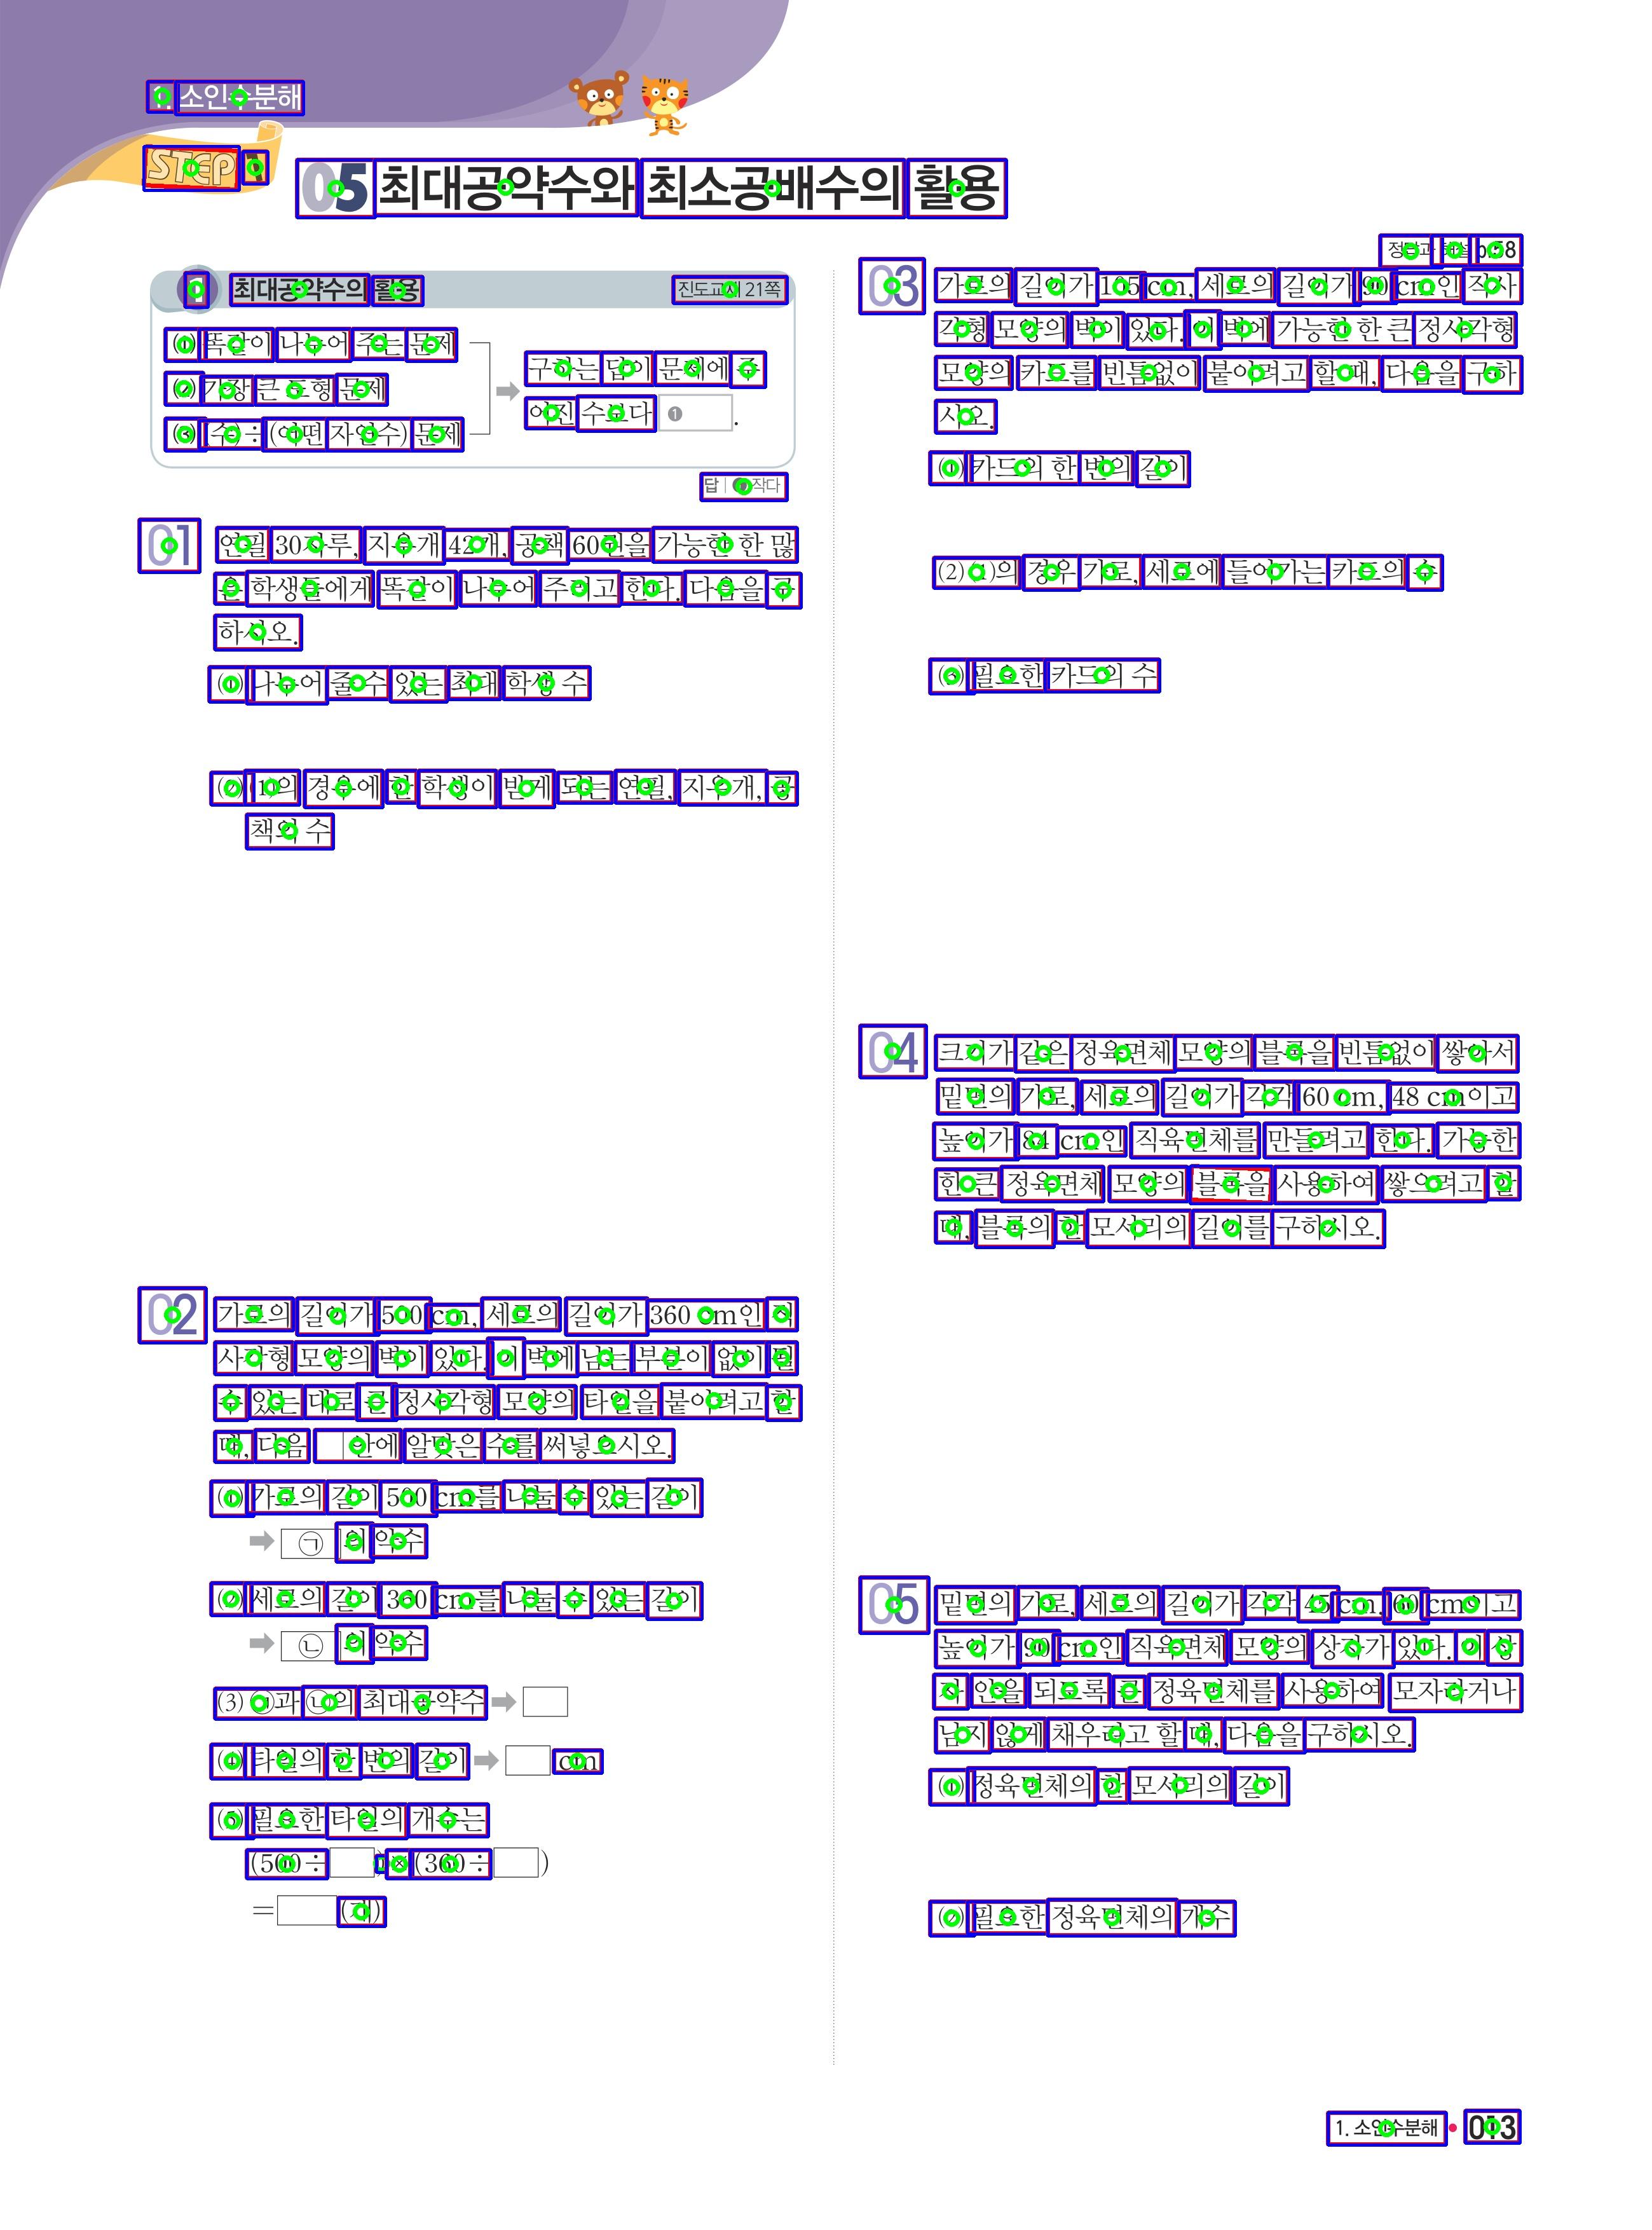

In [91]:
imshow(ori_img)

In [92]:
# 문항 번호 추출 알고리즘
# 1. 퀴즈영역에서 발문이 여러개 이면, y좌표가 가장 작은 (최상단, top)발문이 문항번호를 가지고 있을 유력 후보이다.
# 2. 발문에서 가장 왼쪽,상단 글자 영역을 문항 번호를 가지는 유력 후보로 본다. 문항 번호가 없을 수 있음 -> 체크체크 수학 45페이지 참조
# 유력후보가 없다면 글자영역 다 검사 


쪽번호는 추출은 의미가 없음





In [93]:
ocr_data

{'version': 'V2',
 'requestId': 'de1a12f4-6e2c-46e7-91ef-8808321be203',
 'timestamp': 1681793007948,
 'images': [{'uid': '25658df39d814d4080c5cb16028ad7cf',
   'name': 'demo',
   'inferResult': 'SUCCESS',
   'message': 'SUCCESS',
   'validationResult': {'result': 'NO_REQUESTED'},
   'convertedImageInfo': {'width': 2599,
    'height': 3508,
    'pageIndex': 0,
    'longImage': False},
   'fields': [{'valueType': 'ALL',
     'boundingPoly': {'vertices': [{'x': 232.0, 'y': 128.0},
       {'x': 279.0, 'y': 128.0},
       {'x': 279.0, 'y': 175.0},
       {'x': 232.0, 'y': 175.0}]},
     'inferText': '1.',
     'inferConfidence': 1.0,
     'type': 'NORMAL',
     'lineBreak': False,
     'rect_info': [232, 128, 48, 48],
     'centroid': [255, 151],
     'polyline': array([[232, 128],
            [279, 128],
            [279, 175],
            [232, 175]])},
    {'valueType': 'ALL',
     'boundingPoly': {'vertices': [{'x': 276.0, 'y': 128.0},
       {'x': 476.0, 'y': 128.0},
       {'x': 476.0